# Visualize coordinate predictions of spatial transcriptomics slides

In [25]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
import matplotlib.pyplot as plt
from PIL import Image
from moscot.problems.cross_modality import TranslationProblem
from tqdm import tqdm
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

### Load the necessary data

In [2]:
# Use the predictions from sampled targets fused
adata_histo = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/models/sampled_targets_fused/adata_target.h5ad")
adata_st = sc.read_h5ad("/p/project1/hai_fzj_bda/koenig8/ot/models/sampled_targets_fused/adata_src.h5ad")
adata_histo, adata_st

(AnnData object with n_obs × n_vars = 50156 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'fraction'
     obsm: 'brain_area_onehot', 'uni_embedding', 'uni_pca_95',
 AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'fraction'
     obsm: 'brain_area_onehot', 'pca_embedding', 'transformed')

In [3]:
# Also load the original data
spatial_data = sc.read_h5ad("/p/project1/hai_fzj_bda/berr1/Data/Zhuang-ABCA-1_with_nicheformer_annotation.h5ad")
spatial_data

AnnData object with n_obs × n_vars = 2525999 × 1122
    obs: 'abc_sample_id', 'brain_section_label', 'brain_section_label_adata', 'class', 'class_color', 'cluster', 'cluster_alias', 'cluster_color', 'cluster_confidence_score', 'donor_genotype', 'donor_label', 'donor_sex', 'feature_matrix_label', 'high_quality_transfer', 'neurotransmitter', 'neurotransmitter_color', 'parcellation_category', 'parcellation_category_color', 'parcellation_division', 'parcellation_division_color', 'parcellation_index', 'parcellation_organ', 'parcellation_organ_color', 'parcellation_structure', 'parcellation_structure_color', 'parcellation_substructure', 'parcellation_substructure_color', 'subclass', 'subclass_color', 'subclass_confidence_score', 'supertype', 'supertype_color', 'x', 'x_ccf', 'y', 'y_ccf', 'z', 'z_ccf', 'parcellation_nicheformer'
    var: 'gene_symbol'
    uns: 'normalization'
    obsm: 'pca'

In [4]:
image_path = "/p/project1/hai_fzj_bda/berr1/Data/atlas_images"
images = {}
for file in os.listdir(image_path):
    if file.startswith("."):
        continue
    images[file.split(".")[0]] = np.array(Image.open(os.path.join(image_path, file)))
len(images)

/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (91753664 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (91410432 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (91234304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/p/project1/hai_fzj_bda/koenig8/jupyter/kernels/opt_transport/lib/python3.10/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (89653248 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS a

132

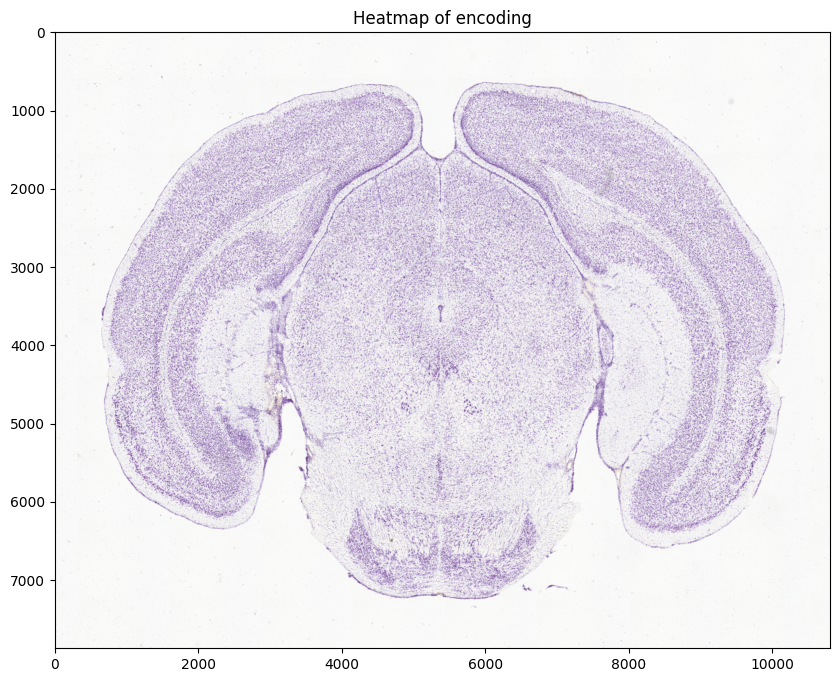

In [5]:
plt.figure(figsize=(10, 8))  # Adjust size
plt.imshow(images["100960033"], aspect="auto")  # Use "viridis" or another colormap
plt.title("Heatmap of encoding")
plt.show()

### Get the predictions

In [6]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/models/sampled_targets_fused"
fractions = 4
adatas_src = []
adatas_target = []
tps = []
transitions = []
perm_N = np.load(os.path.join(path, "permutation_source.npy"))
perm_M = np.load(os.path.join(path, "permutation_target.npy"))
N = adata_st.shape[0]
M = adata_histo.shape[0]
step_N = int(np.ceil(N/fractions))
step_M = int(np.ceil(M/fractions))

for i in range(fractions):
    if fractions > 1:
        ad_src = adata_st[perm_N[i*step_N:(i+1)*step_N], :]
        ad_target = adata_histo[perm_M[i*step_M:(i+1)*step_M], :]
    
    tp = TranslationProblem(adata_src=ad_src, adata_tgt=ad_target)
    tp = tp.prepare(src_attr="pca_embedding", tgt_attr="uni_pca_95", joint_attr="brain_area_onehot")
    tp = tp.load(os.path.join(path, f"opt_transport{str(i)}.pkl"))
    tps.append(tp)
    adatas_target.append(ad_target)
    adatas_src.append(ad_src)
    transitions.append(tp[('src', 'tgt')].solution.transport_matrix.__array__())
    
[t.shape for t in transitions]

WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      
WARNING  Densifying data in `adata.obsm['brain_area_onehot']`                                                      


[(12500, 12539), (12500, 12539), (12500, 12539), (12500, 12539)]

In [10]:
predictions_T = []
true_T = []
color_by_fraction = []
for i in tqdm(range(fractions)):
    ad_st = adatas_src[i]
    ad_histo = adatas_target[i]
    
    histo_coordinates = ad_histo.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
    spatial_coordinates = ad_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy()
    T = transitions[i]
    true_T.append(spatial_coordinates)

    for j in range(ad_st.shape[0]):
        color_by_fraction.append(i)
        t_j = T[j] / np.sum(T[j])
        t_j = np.repeat(t_j[:, None], 3, axis=1)
        prediction = np.sum(histo_coordinates * t_j, axis = 0)
        predictions_T.append(prediction)

predictions = np.vstack(predictions_T)
true_T = np.vstack(true_T)

r2_score(true_T, predictions)

100%|██████████| 4/4 [00:19<00:00,  4.97s/it]


0.10334821840770214

#### Annotate them in the orginal adata

In [23]:
adata_st = adata_st[perm_N]
adata_st.obs[["x_pred", "y_pred", "z_pred"]] = predictions
adata_st = adata_st[np.argsort(perm_N)]
r2_score(
    adata_st.obs.loc[:, ["x_st", "y_st", "z_st"]].to_numpy(),
    adata_st.obs.loc[:, ["x_pred", "y_pred", "z_pred"]].to_numpy()
)

/tmp/ipykernel_3228058/2203195083.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_st.obs[["x_pred", "y_pred", "z_pred"]] = predictions


0.10334821840769752

# Try to overlay the predicted coordinates on the respective slides

In [21]:
adata_st.obs.brain_section_label.unique()

['Zhuang-ABCA-1.079', 'Zhuang-ABCA-1.089', 'Zhuang-ABCA-1.085', 'Zhuang-ABCA-1.077', 'Zhuang-ABCA-1.087', ..., 'Zhuang-ABCA-1.022', 'Zhuang-ABCA-1.014', 'Zhuang-ABCA-1.024', 'Zhuang-ABCA-1.011', 'Zhuang-ABCA-1.012']
Length: 129
Categories (129, object): ['Zhuang-ABCA-1.010', 'Zhuang-ABCA-1.011', 'Zhuang-ABCA-1.012', 'Zhuang-ABCA-1.013', ..., 'Zhuang-ABCA-1.138', 'Zhuang-ABCA-1.139', 'Zhuang-ABCA-1.140', 'Zhuang-ABCA-1.141']

In [37]:
adata_st.obs.loc[
    :, ["x_st", "y_st", "z_st"]
].max()

x_st    12.622358
y_st     7.504464
z_st     5.874929
dtype: float64

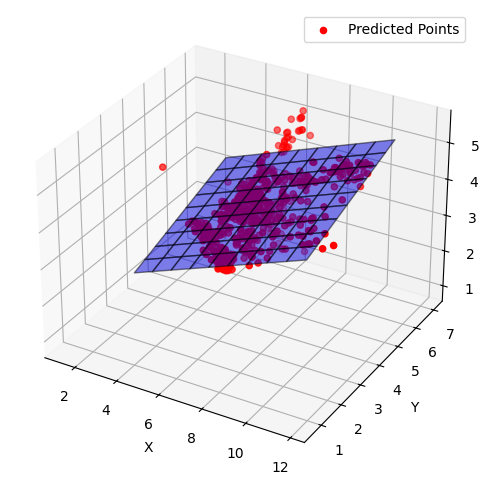

In [39]:
# Sample 3D predictions (Replace with your actual model predictions)
predictions = np.random.rand(100, 3) * 10  # Example noisy points in space
actual = adata_st.obs.loc[
    adata_st.obs.brain_section_label == "Zhuang-ABCA-1.079", ["x_pred", "y_pred", "z_pred"]
].to_numpy()
predictions = actual
# Fit a plane using PCA (which finds the best-fit plane in least-squares sense)
pca = PCA(n_components=2)
pca.fit(predictions)  # Fit PCA on the points

# Plane normal (third eigenvector)
normal = np.cross(pca.components_[0], pca.components_[1])
d = -np.dot(normal, pca.mean_)  # Compute offset for plane equation

# Generate grid of (x, y) points for the plane
x_range = np.linspace(min(predictions[:, 0]), max(predictions[:, 0]), 10)
y_range = np.linspace(min(predictions[:, 1]), max(predictions[:, 1]), 10)
X, Y = np.meshgrid(x_range, y_range)
Z = (-normal[0] * X - normal[1] * Y - d) / normal[2]  # Solve for Z

# Create a 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # Correct way to create a 3D axis

# Scatter plot of original 3D points
ax.scatter(predictions[:, 0], predictions[:, 1], predictions[:, 2], color='red', label="Predicted Points")

# Plot the fitted plane
ax.plot_surface(X, Y, Z, alpha=0.5, color='blue', edgecolor='k')

# Set axis limits to match the brain coordinates
ax.set_xlim([0.539969, 12.622358])
ax.set_ylim([0.174226, 7.504464])
ax.set_zlim([0.557578, 5.874929])

# Labels
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

plt.legend()
plt.show()

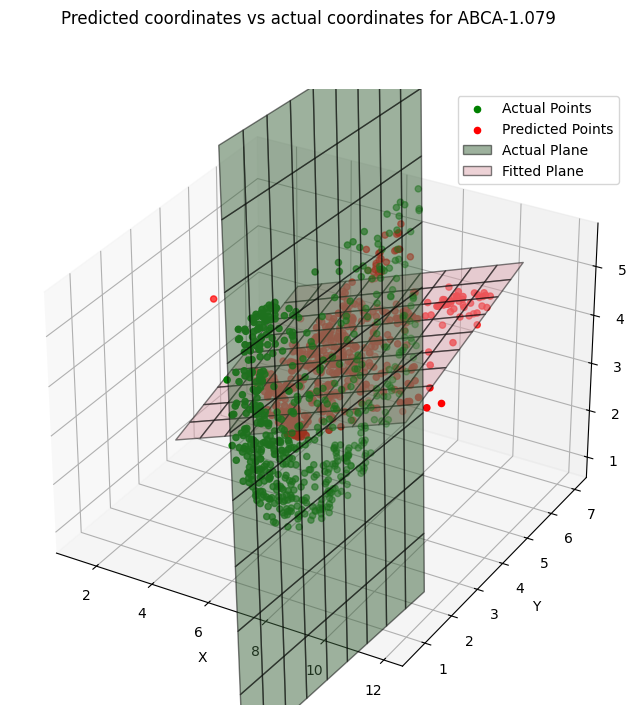

In [51]:
def fit_plane(points):
    """ Fit a plane to 3D points using PCA and return normal and mean """
    pca = PCA(n_components=2)
    pca.fit(points)
    normal = np.cross(pca.components_[0], pca.components_[1])
    d = -np.dot(normal, pca.mean_)
    x_range = np.linspace(min(points[:, 0]), max(points[:, 0]), 10)
    y_range = np.linspace(min(points[:, 1]), max(points[:, 1]), 10)
    X, Y = np.meshgrid(x_range, y_range)
    Z = (-normal[0] * X - normal[1] * Y - d) / normal[2]
    return X, Y, Z

sample_true = adata_st.obs.loc[
    adata_st.obs.brain_section_label == "Zhuang-ABCA-1.079", ["x_st", "y_st", "z_st"]
].to_numpy()
sample_pred = adata_st.obs.loc[
    adata_st.obs.brain_section_label == "Zhuang-ABCA-1.079", ["x_pred", "y_pred", "z_pred"]
].to_numpy()

def plot_coordinates(true_points, predicted_points):
    # Fit planes
    X_true, Y_true, Z_true = fit_plane(true_points)
    X_pred, Y_pred, Z_pred = fit_plane(predicted_points)
    
    # Create a 3D plot
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot of original 3D points
    ax.scatter(true_points[:, 0], true_points[:, 1], true_points[:, 2], color='green', label="Actual Points")
    ax.scatter(predicted_points[:, 0], predicted_points[:, 1], predicted_points[:, 2], color='red', label="Predicted Points")
        
    # Plot the two fitted planes
    ax.plot_surface(X_true, Y_true, Z_true, alpha=0.5, color='lightgreen', edgecolor='k', label="Actual Plane")
    ax.plot_surface(X_pred, Y_pred, Z_pred, alpha=0.5, color='pink', edgecolor='k', label="Fitted Plane")
    
    # Set custom axis limits corresponding to ccf brain dimensions
    ax.set_xlim([0.539969, 12.622358])
    ax.set_ylim([0.174226, 7.504464])
    ax.set_zlim([0.557578, 5.874929])
    
    # Labels
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend()
    return fig

plot_coordinates(sample_true, sample_pred)
plt.suptitle("Predicted coordinates vs actual coordinates for ABCA-1.079")
plt.show()

In [44]:
Z_pred.shape

(10, 10)

In [46]:
X_pred.shape

(10, 10)